In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [3]:
df = pd.read_csv('../beforecovid.csv')

df["Year"] = df["Date"].str.split("-").str[2]

In [4]:
df["Year"].value_counts()

19    4842
17    3447
18    3369
20    1804
Name: Year, dtype: int64

In [5]:

df_assigned = df

In [6]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [7]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use',"lah","haha","#","%"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [8]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


df_assigned.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"[mine, year, resale, bomb, shelter, ledge, noi...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"[kimurayuki, mine, year, resale, bomb, shelter...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"[punggolbto, model, floor, plan, building, bto...",punggolbto per actual hdb models floor plans p...,2019-01-18
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"[resale, agent, unit, renovation, source, info...",purchased resale flat recently without agent u...,2018-10-19
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"[hdb, website, resale, transaction, market, pr...",add go hdb website check recent 6mths resale t...,2018-10-20


In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


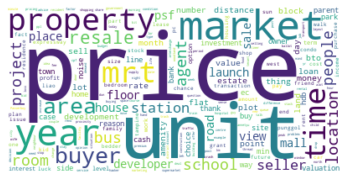

In [10]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='frequency', ylabel='pairs'>

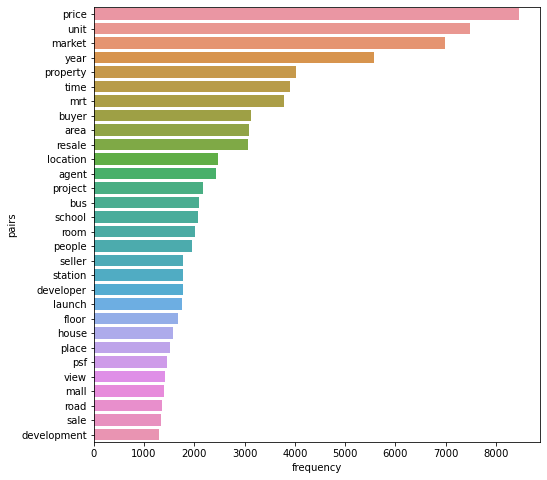

In [11]:
new_tokens = []
for i in df_assigned["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [12]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:3])

[['mine', 'year', 'resale', 'bomb', 'shelter', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'crazyclubx', 'time', 'house', 'end', 'peace', 'change', 'year', 'move', 'door', 'noise', 'door', 'neighbour', 'r', 'pain'], ['kimurayuki', 'mine', 'year', 'resale', 'bomb', 'shelter', 'ledge', 'noise', 'traffic', 'supermarket', 'loading', 'bay', 'mine', 'year', 'resale', 'home', 'traffic', 'road', 'traffic', 'noise', 'aircon', 'noise', 'neighbour', 'door', '2am', 'thing', '3am', 'timing', 'time', 'ppl', 'sleep', 'shld', 'inconsiderate', 'neighbour'], ['punggolbto', 'model', 'floor', 'plan', 'building', 'bto', 'view', 'unit', 'area', 'site', 'word', 'price', 'proximity', 'station', 'monkey', 'island', 'venture', 'food']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'bay'), (1, 'bomb'), (2, 'change'), (3, 'crazyclubx'), (4, 'door'), (5, 'end'), (6, 'house'), (7, 'ledge'), (8, 'loading'), (9, 'mine'), (10, 'move'), (11, 'neighbour'), (12, 'noise'), (13, 'pain'), (14, 'peace'), (15, 'r'), (16, 'resale'), (17, 'shelter'), (18, 'supermarket'), (19, 'time'), (20, 'traffic'), (21, 'year'), (22, '2am'), (23, '3am'), (24, 'aircon'), (25, 'home'), (26, 'inconsiderate'), (27, 'kimurayuki'), (28, 'ppl'), (29, 'road'), (30, 'shld'), (31, 'sleep'), (32, 'thing'), (33, 'timing'), (34, 'area'), (35, 'bto'), (36, 'building'), (37, 'floor'), (38, 'food'), (39, 'island'), (40, 'model'), (41, 'monkey'), (42, 'plan'), (43, 'price'), (44, 'proximity'), (45, 'punggolbto'), (46, 'site'), (47, 'station'), (48, 'unit'), (49, 'venture')]

Total Vocabulary Size: 7820


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [15]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [16]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5912226869571262
Perplexity Score:  -6.84843058229501

topic number:  3
Coherence Score:  0.6255681147718185
Perplexity Score:  -6.815645035723682

topic number:  4
Coherence Score:  0.6237590825312826
Perplexity Score:  -6.798900468632629

topic number:  5
Coherence Score:  0.6438993747661053
Perplexity Score:  -6.813490309985931

topic number:  6
Coherence Score:  0.6434827723573178
Perplexity Score:  -6.834970951046373

topic number:  7
Coherence Score:  0.6306700641624285
Perplexity Score:  -6.83745097468512

topic number:  8
Coherence Score:  0.5859929503299378
Perplexity Score:  -6.844236621728927

topic number:  9
Coherence Score:  0.5946777790108848
Perplexity Score:  -6.886747012498104

topic number:  10
Coherence Score:  0.604238814120695
Perplexity Score:  -6.974738239497528

topic number:  11
Coherence Score:  0.5881229652979376
Perplexity Score:  -7.144097751454169

topic number:  12
Coherence Score:  0.5381202529162129
Perplexity Score

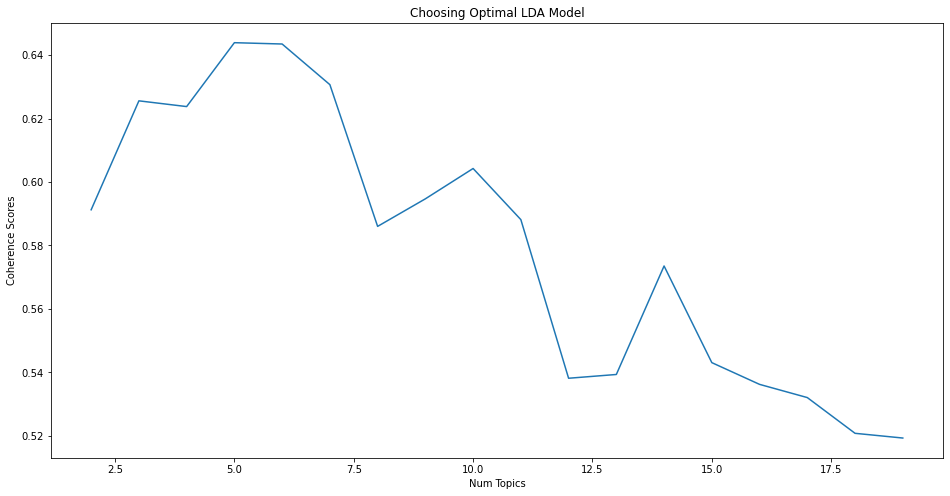

In [17]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [18]:
ntopics_des_name = 10

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [19]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.025*"school" + 0.020*"time" + 0.016*"night" + 0.016*"family" + '
  '0.015*"day" + 0.014*"water" + 0.014*"pm" + 0.012*"air" + 0.011*"work" + '
  '0.011*"issue"'),
 (1,
  '0.127*"unit" + 0.031*"bedroom" + 0.027*"m" + 0.023*"affinity" + '
  '0.018*"price" + 0.016*"psf" + 0.014*"site" + 0.014*"floor" + '
  '0.014*"marketing" + 0.013*"development"'),
 (2,
  '0.080*"price" + 0.046*"project" + 0.041*"launch" + 0.031*"psf" + '
  '0.029*"unit" + 0.027*"developer" + 0.022*"location" + 0.021*"buyer" + '
  '0.021*"resale" + 0.021*"bedder"'),
 (3,
  '0.070*"bus" + 0.048*"mrt" + 0.040*"station" + 0.028*"area" + 0.023*"line" + '
  '0.019*"plot" + 0.018*"mall" + 0.017*"walk" + 0.017*"distance" + '
  '0.015*"min"'),
 (4,
  '0.074*"market" + 0.066*"property" + 0.040*"price" + 0.023*"time" + '
  '0.020*"year" + 0.020*"people" + 0.017*"developer" + 0.012*"land" + '
  '0.011*"money" + 0.009*"investment"'),
 (5,
  '0.051*"unit" + 0.035*"noise" + 0.032*"floor" + 0.028*"expressway" + '
  '0.028*"blo

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [21]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [22]:
df_assigned['Topic'] = topic_num

In [23]:
df_assigned

,Date,text,Year,Month,clean_text,join_clean_text,real_Date,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"[mine, year, resale, bomb, shelter, ledge, noi...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25,"[0, 6, 5]"
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"[kimurayuki, mine, year, resale, bomb, shelter...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25,"[5, 6, 9, 0]"
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"[punggolbto, model, floor, plan, building, bto...",punggolbto per actual hdb models floor plans p...,2019-01-18,"[3, 2, 5]"
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"[resale, agent, unit, renovation, source, info...",purchased resale flat recently without agent u...,2018-10-19,"[8, 5, 0, 6]"
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"[hdb, website, resale, transaction, market, pr...",add go hdb website check recent 6mths resale t...,2018-10-20,[8]
...,...,...,...,...,...,...,...,...
13457,12-Oct-19,Van Holland Former Toho Mansion Holland Villag...,19,Oct,"[development, heart, development, development,...",van holland former toho mansion holland villag...,2019-10-12,"[7, 1, 3, 0, 2, 6, 5]"
13458,13-Oct-19,Another project:\nFinal 15 units of T.O.P Read...,19,Oct,"[project, unit, boutique, project, 2rms, 4bdrm...",another project final 15 units p ready boutiqu...,2019-10-13,"[2, 8, 9, 7, 0]"
13459,13-Oct-19,Zetrio2006 said:\nAnother project:\nFinal 15 u...,19,Oct,"[zetrio2006, project, unit, boutique, project,...",zetrio2006 another project final 15 units p re...,2019-10-13,"[2, 5, 8, 6, 9, 7, 0]"
13460,13-Oct-19,bolster said:\nWow... did you try walking to t...,19,Oct,[],bolster wow try walking holland v mrt really 5...,2019-10-13,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


In [24]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

,Date,text,clean_text,Topic
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...","[mine, year, resale, bomb, shelter, ledge, noi...","[0, 6, 5]"
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,"[kimurayuki, mine, year, resale, bomb, shelter...","[5, 6, 9, 0]"
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,"[punggolbto, model, floor, plan, building, bto...","[3, 2, 5]"
3,19-Oct-18,I have just purchased a resale flat recently w...,"[resale, agent, unit, renovation, source, info...","[8, 5, 0, 6]"
4,20-Oct-18,"Just to add, go to hdb website and check recen...","[hdb, website, resale, transaction, market, pr...",[8]


In [25]:
# des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [26]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.969768142574522
Coherence Score:  0.5597383268836914


## Visualisation

In [27]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.172728 -0.012479       1        1  16.685266
4      0.208027 -0.068465       2        1  13.043738
2      0.112242  0.129987       3        1  11.811140
3     -0.253400  0.031731       4        1  11.306871
5     -0.190793  0.096009       5        1  10.510913
9      0.219533 -0.080266       6        1   9.595666
6     -0.014632  0.087642       7        1   8.667193
7     -0.178493 -0.090217       8        1   8.627083
1      0.013368  0.222130       9        1   5.191131
0     -0.088580 -0.316070      10        1   4.560999, topic_info=          Term         Freq        Total Category  logprob  loglift
48        unit  7194.000000  7194.000000  Default  30.0000  30.0000
1007       bus  2540.000000  2540.000000  Default  29.0000  29.0000
55       agent  2861.000000  2861.000000  Default  28.0000  28.0000
196   property  3921.000000  3921.000000  Default  27.0000  27.0000
43       price  7994.000000  7994.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1096    tenant   110.184136   275.998259  Topic10  -4.8922   2.1694
643       wife   111.607573   307.983092  Topic10  -4.8793   2.0726
846    quality   101.918574   229.321109  Topic10  -4.9701   2.2767
806      place   131.856003  1492.519805  Topic10  -4.7126   0.6611
197       rent   114.689488   599.687060  Topic10  -4.8521   1.4334

[652 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1399      4  0.993877        +
2085      9  0.989528     1.1k
3446      9  0.989800     10yr
1179      3  0.982643  1100psf
1843      3  0.988412  1400psf
...     ...       ...      ...
21        7  0.297325     year
21        8  0.056314     year
21        9  0.027161     year
615       6  0.994805    yield
1049      4  0.988963   yishun

[1196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 3, 4, 6, 10, 7, 8, 2, 1])

## Word Count of Topic Keywords

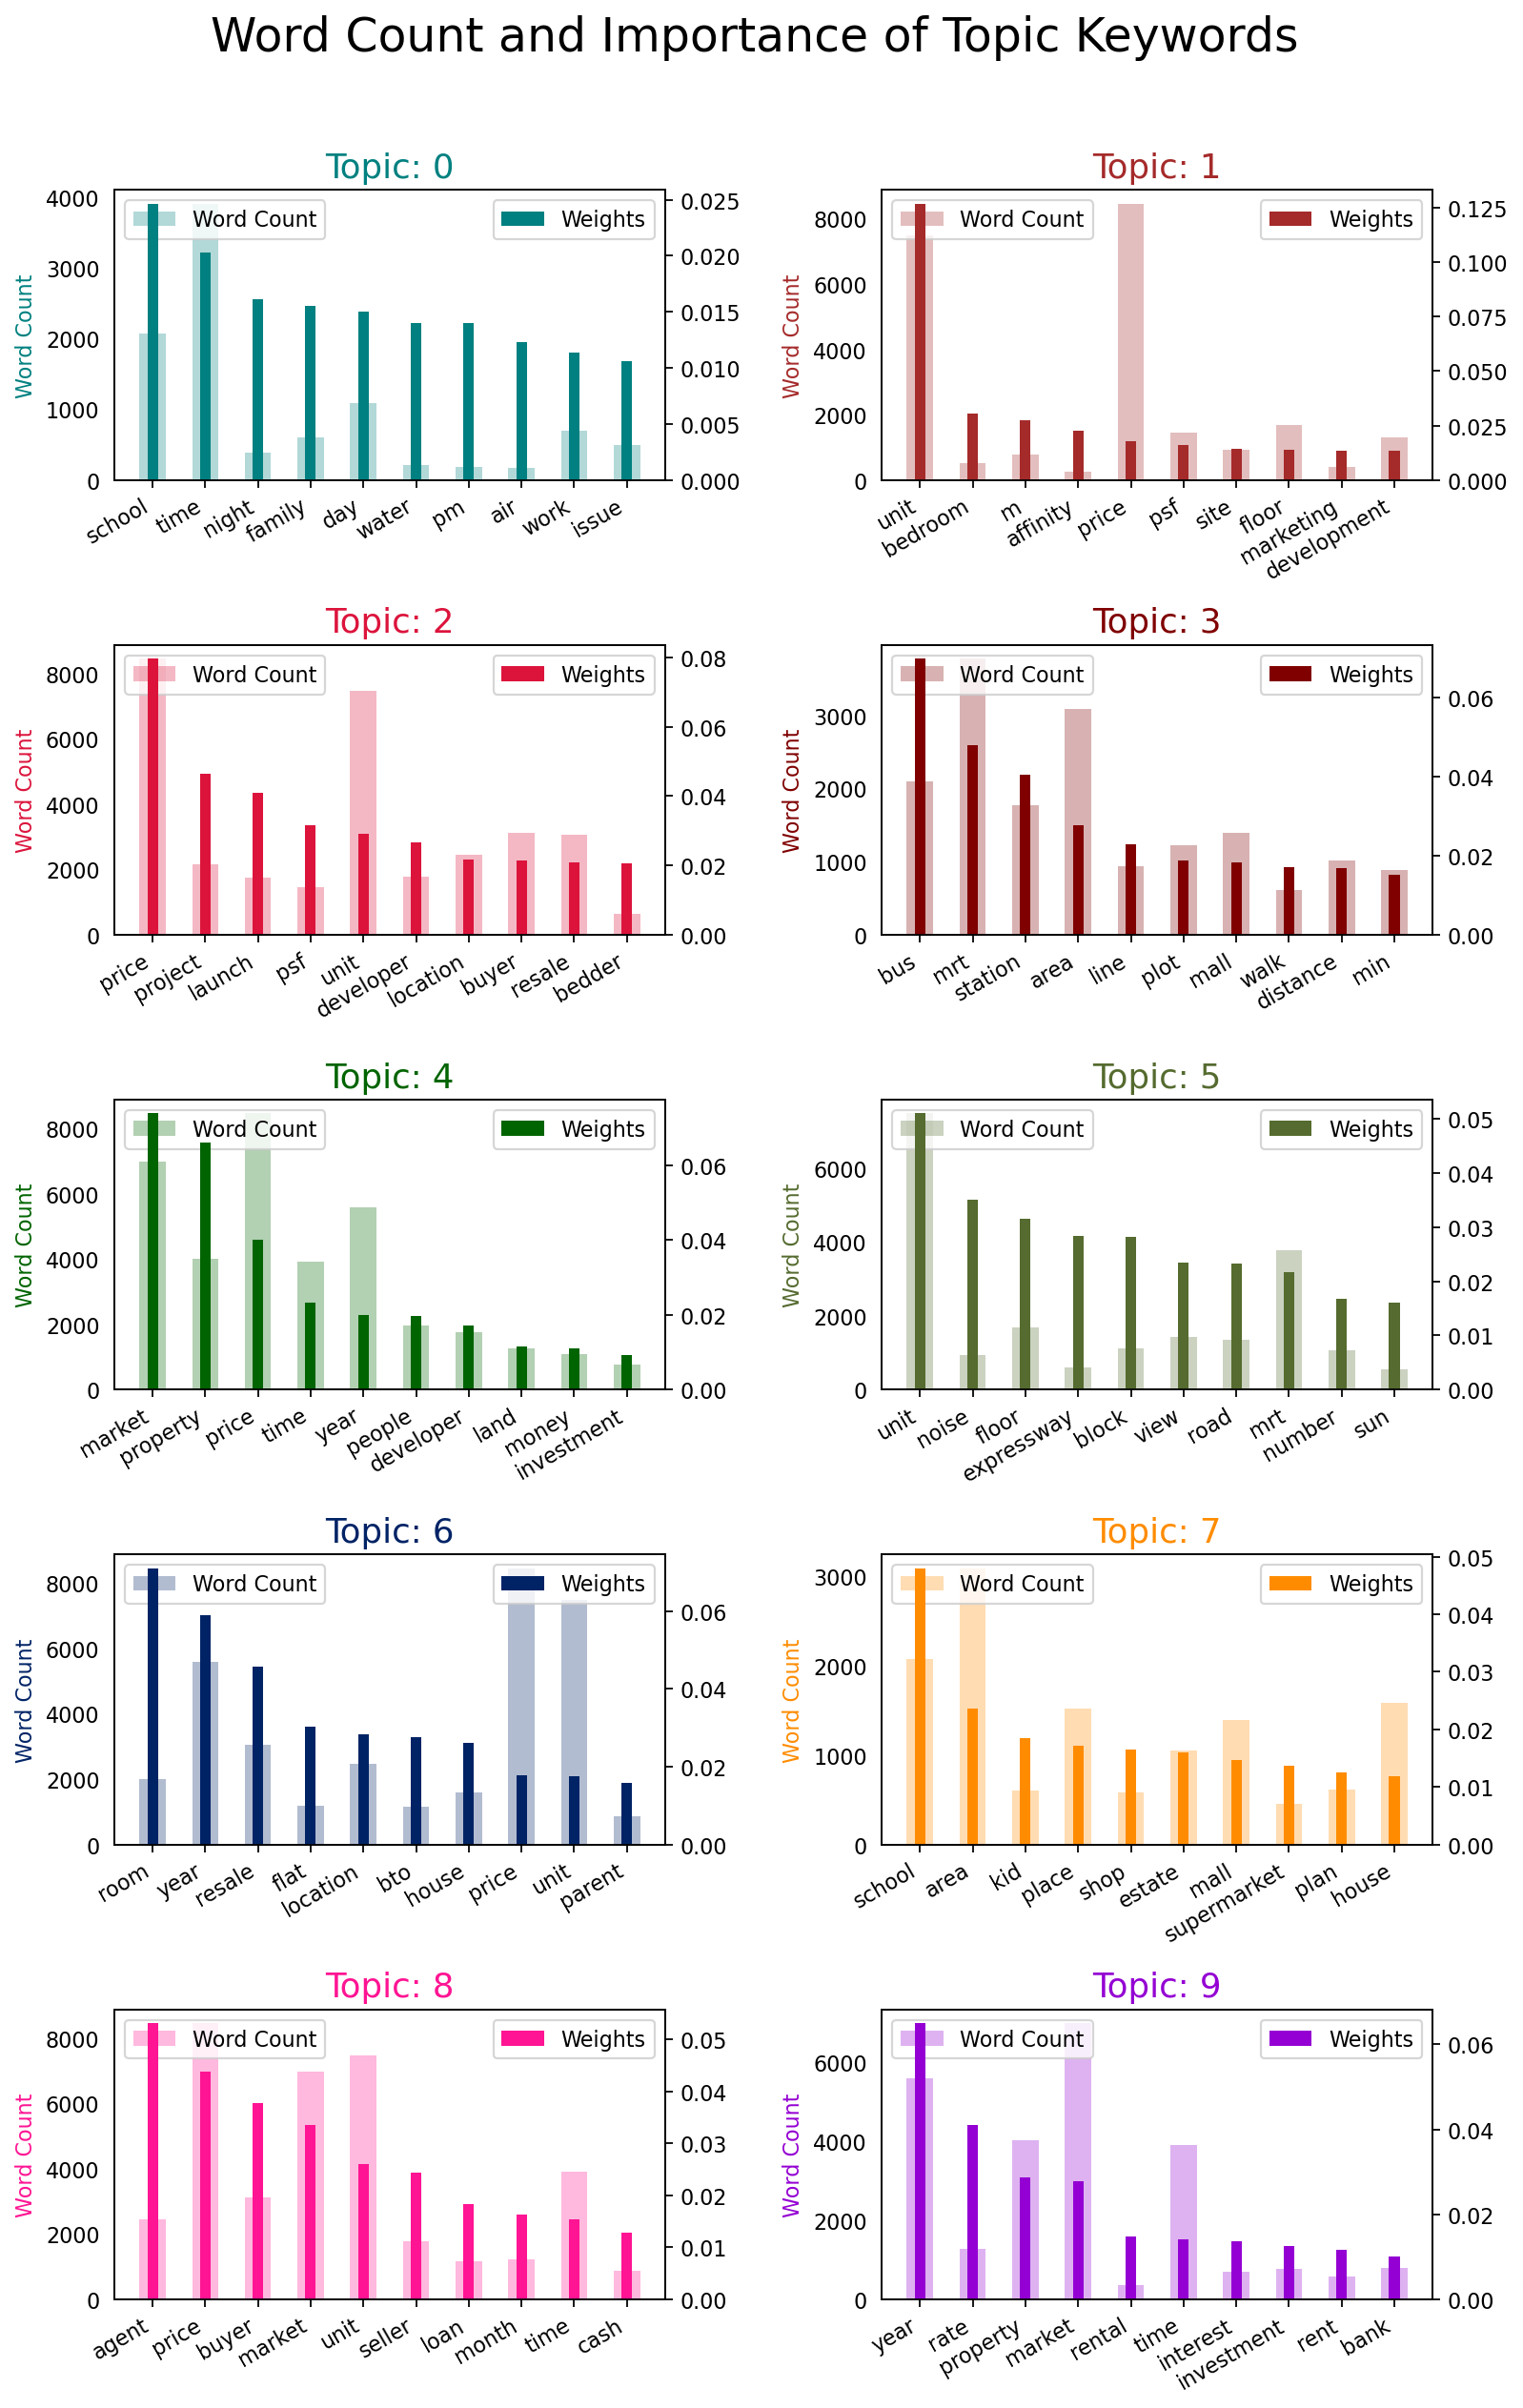

In [29]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
